# Face Identification

Output vector: **16** x float32  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
fcnt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fcnt += 1
        if fcnt < 10 or fcnt > 2190:
            print(os.path.join(dirname, filename))
print(fcnt)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/torchvision-resnet-pretrained/resnet50-0676ba61.pth
/kaggle/input/torchvision-resnet-pretrained/resnet34-b627a593.pth
/kaggle/input/torchvision-resnet-pretrained/resnet101-63fe2227.pth
/kaggle/input/torchvision-resnet-pretrained/resnet18-f37072fd.pth
/kaggle/input/torchvision-resnet-pretrained/resnet152-f82ba261.pth
/kaggle/input/torchvision-resnet-pretrained/resnet152-394f9c45.pth
/kaggle/input/torchvision-resnet-pretrained/resnet101-cd907fc2.pth
/kaggle/input/torchvision-resnet-pretrained/resnet50-11ad3fa6.pth
/kaggle/input/faceid-preprocessed/Felicity_Huffman_2.npz.pkl
/kaggle/input/faceid-preprocessed/Leticia_Van_de_Putte_1.npz.pkl
/kaggle/input/faceid-preprocessed/George_Galloway_4.npz.pkl
/kaggle/input/faceid-preprocessed/Prince_Harry_1.npz.pkl
/kaggle/input/faceid-preprocessed/Emmanuel_Milingo_4.npz.pkl
/kaggle/input/faceid-preprocessed/Eve_Ensler_2.npz.pkl
/kaggle/input/faceid-preprocessed/Carolina_Kluft_5.npz.pkl
/kaggle/input/faceid-preprocessed/Ally_Sheedy_4.np

In [2]:
!df /kaggle/

Filesystem     1K-blocks     Used Available Use% Mounted on
/dev/vda1      121770540 96529812  25224344  80% /


In [3]:
#!mkdir -pv /kaggle/temp
#!rm -Rf /kaggle/temp/*
#!cp -as /kaggle/input/youtube-faces-with-facial-keypoints /kaggle/temp/
#!mv /kaggle/temp/youtube-faces-with-facial-keypoints/*/*/*.npz /kaggle/temp/youtube-faces-with-facial-keypoints/
#!ls /kaggle/temp/youtube-faces-with-facial-keypoints/ | wc

In [4]:
#data_dir = '/kaggle/temp/youtube-faces-with-facial-keypoints'
#data_dir = '/kaggle/input/faceid-preprocessed-small'
data_dir = '/kaggle/input/faceid-preprocessed'

In [5]:
# Updating to the recent pretrained data
!rm -Rf ~/.cache/torch/hub/checkpoints/
!mkdir -pv ~/.cache/torch/hub/checkpoints/
!cp -avs /kaggle/input/torchvision-resnet-pretrained/resnet*.pth ~/.cache/torch/hub/checkpoints/
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth ~/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth ~/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth ~/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
!ls -l ~/.cache/torch/hub/checkpoints/

mkdir: created directory '/home/ubuntu/.cache/torch/hub/checkpoints/'
'/kaggle/input/torchvision-resnet-pretrained/resnet101-63fe2227.pth' -> '/home/ubuntu/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet101-cd907fc2.pth' -> '/home/ubuntu/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet152-394f9c45.pth' -> '/home/ubuntu/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet152-f82ba261.pth' -> '/home/ubuntu/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet18-f37072fd.pth' -> '/home/ubuntu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet34-b627a593.pth' -> '/home/ubuntu/.cache/torch/hub/checkpoints/resnet34-b627a593.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet50-0676ba61.pth' -> '/home/ubuntu/.cache/torch/hu

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
df = pd.read_csv(f'{data_dir}/youtube_faces_with_keypoints_full.csv')
df

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0
...,...,...,...,...,...,...,...
2189,Yossi_Beilin_3,Yossi_Beilin,240.0,243.0,240.0,110.258333,2.0
2190,Zahir_Shah_0,Zahir_Shah,196.0,200.0,143.0,93.944056,2.0
2191,Zahir_Shah_1,Zahir_Shah,240.0,293.0,240.0,155.495833,2.0
2192,Zoran_Djindjic_0,Zoran_Djindjic,230.0,237.0,240.0,98.908333,2.0


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#from torchinfo import summary

In [9]:
import PIL
import cv2

class NormalizeTransform:
    def __init__(self, ratio=0.333):
        self.ratio = ratio

        self.jawPoints          = [ 0,17]
        self.rigthEyebrowPoints = [17,22]
        self.leftEyebrowPoints  = [22,27]
        self.noseRidgePoints    = [27,31]
        self.noseBasePoints     = [31,36]
        self.rightEyePoints     = [36,42]
        self.leftEyePoints      = [42,48]
        self.outerMouthPoints   = [48,60]
        self.innerMouthPoints   = [60,68]

        self.norm_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.functional.autocontrast,
            torchvision.transforms.functional.to_grayscale,
            torchvision.transforms.ToTensor(),
        ])

    def __call__(self, data, landmarks):
        data = self.face_transform(data, landmarks)
        img = PIL.Image.fromarray(data)
        data = self.norm_transform(img)
        return data

    def face_transform(self, data, landmarks):
        # see FaceId-Normalization.ipynb
        pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
        pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
        pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
        src_pts = np.float32([pt1, pt2, pt3])
        dst_pts = np.float32([
            [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
            [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
            [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
        ])
        M = cv2.getAffineTransform(src_pts, dst_pts)
        data = cv2.warpAffine(data, M, data.shape[:2])
        return data
    
    def avg(self, pts):
        x = sum(x for x,y in pts) / len(pts)
        y = sum(y for x,y in pts) / len(pts)
        return x, y

In [10]:
import random
import pickle

random.seed()

class YouTubeFacesDataset(torch.utils.data.Dataset):
    def __init__(self, df, folder = '.', transform = NormalizeTransform(),
                 cache_lim = 200,
                 preload = False, preprocess = False,
                 anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1,
                 stochastic_set_fraction = 0.8):
        self.transform = transform
        self.cache = {}
        self.cache_lim = 0 if preload else cache_lim
        self.preprocessed_cache = {}
        self.data = {}
        for p in tqdm(df['personName'].unique(), desc='Loading data'):
            self.data[p] = []
            for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
                fp = f'{folder}/{fn}.npz'
                cnt = int(cnt)
                self.data[p] += [(fp, i) for i in range(cnt)]
                if preload:
                    self.cache_lim += 1
                    imgs, lms = self._cache_get(fp)
                    assert imgs.shape[-1] == cnt
                    assert lms.shape[-1] == cnt
                if preprocess:
                    pfp = self._preprocess(fp)
                    imgs = self._load_preprocessed(pfp)
                    assert len(imgs) == cnt
                    self.preprocessed_cache[fp] = imgs
        self.persons = list(self.data.keys())
        self.neg_data = {}
        for p in self.persons:
            self.neg_data[p] = []
            for p_neg in self.persons:
                if p_neg == p:
                    continue
                self.neg_data[p] += self.data[p_neg]
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def resize(self, anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1, stochastic_set_fraction = 0.8):
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def __len__(self):
        return len(self.persons) * self.anchor_set_len * self.positive_set_len * self.negative_set_len
    
    def __getitem__(self, index):
        p_i = index // self.negative_set_len // self.positive_set_len // self.anchor_set_len
        assert p_i >= 0
        assert p_i < len(self.persons)
        p = self.persons[p_i]
        if self.negative_set_len > len(self.neg_data[p]) * self.stochastic_set_fraction:
            negative_i = index % self.negative_set_len
            negative_i = negative_i % len(self.neg_data[p])
        else:
            negative_i = random.randint(0, len(self.neg_data[p]) - 1)
        assert negative_i >= 0
        assert negative_i < len(self.neg_data[p])
        if self.positive_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            positive_i = (index // self.negative_set_len) % self.positive_set_len
            positive_i = positive_i % len(self.data[p])
        else:
            positive_i = random.randint(0, len(self.data[p]) - 1)
        assert positive_i >= 0
        assert positive_i < len(self.data[p])
        if self.anchor_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            anchor_i = (index // self.negative_set_len // self.positive_set_len) % self.anchor_set_len
            anchor_i = anchor_i % len(self.data[p])
        else:
            anchor_i = random.randint(0, len(self.data[p]) - 1)
        assert anchor_i >= 0
        assert anchor_i < len(self.data[p])
        return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
    
    def _load(self, fp, i):
        if fp in self.preprocessed_cache:
            assert i < len(self.preprocessed_cache[fp]), (fp, i, len(self.preprocessed_cache[fp]))
            if self.preprocessed_cache[fp][i] is not None:
                return self.preprocessed_cache[fp][i]
        imgs, lms = self._cache_get(fp)
        assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
        data = imgs[:,:,:,i]
        assert i < lms.shape[-1], (fp, i, lms.shape[-1])
        lms = lms[:,:,i]
        if self.transform:
            data = self.transform(data, lms)
        return data
    
    def _cache_get(self, fp):
        if fp in self.cache:
            return self.cache[fp]
        if len(self.cache) > self.cache_lim:
            idx = random.randint(0, len(self.cache) - 1)
            key = list(self.cache.keys())[idx]
            del self.cache[key]
        d = np.load(fp)
        # trigger lazy loading
        self.cache[fp] = (d['colorImages'], d['landmarks2D'])
        return self.cache[fp]
    
    def _preprocess(self, fp):
        pfp = f'{fp}.pkl'
        if not os.path.exists(pfp):
            imgs, lms = self._cache_get(fp)
            d = [self._load(fp, i) for i in range(imgs.shape[-1])]
            with open(pfp, 'wb') as f:
                pickle.dump(d, f)
        return pfp
    
    def _load_preprocessed(self, pfp):
        with open(pfp, 'rb') as f:
            return pickle.load(f)

dataset = YouTubeFacesDataset(df, data_dir, preprocess = True)
len(dataset)

Loading data: 100%|██████████| 828/828 [01:04<00:00, 12.87it/s]


828

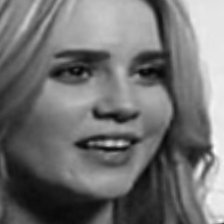

In [11]:
to_pil_transform = torchvision.transforms.ToPILImage()
to_pil_transform(dataset[0][1])

In [12]:
def dev_list():
    return [torch.cuda.get_device_properties(torch.device(f'cuda:{i}')) for i in range(torch.cuda.device_count())]

def train_triplet_multigpu(model, dataset, num_epochs,
                           lr = 0.001, batch_size = 16,
                           target_loss = 0, lr_reduct_loss_threshold = 0.02):
    model.train()
    model = nn.DataParallel(model)
    model.to(torch.device('cuda'))
    
    loss = nn.TripletMarginLoss()
    loss_history = []
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    print(f'lr: {lr}')
    for epoch in range(1, num_epochs+1):
        loss_accum = 0
        loss_cnt = 0
        for xa, xp, xn in tqdm(data_loader, desc=f'train {epoch}/{num_epochs}'):
            ya = model(xa)
            yp = model(xp)
            yn = model(xn)
            loss_data = loss(ya, yp, yn)
            
            optimizer.zero_grad()
            loss_data.backward()
            optimizer.step()
            
            loss_accum += float(loss_data)
            loss_cnt += 1

        loss_value = loss_accum / loss_cnt
        print(f'loss: {loss_value}')

        if loss_history and loss_value > loss_history[-1] * (1 - lr_reduct_loss_threshold):
            lr *= 0.1
            print(f'lr: {lr}')
            optimizer = optim.Adam(model.parameters(), lr=lr)
        
        loss_history.append(loss_value)
        
        if loss_value <= target_loss:
            print(f'target loss {target_loss} reached')
            break

    return loss_history

In [13]:
def create_faceid_model():
    model = torchvision.models.resnet50(weights='DEFAULT')
    model.fc = nn.Linear(model.fc.in_features, 16)
    return model

def grayscale_fix_model(model):
    w = model.conv1.weight.data.sum(axis=1).reshape(64, 1, 7, 7)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.conv1.weight.data = w
    return model

def set_trainable(model):
    model.requires_grad_(False)
    model.fc.requires_grad_(True)

model = create_faceid_model()
model = grayscale_fix_model(model)
set_trainable(model)
#summary(model)
model.conv1, model.fc

(Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Linear(in_features=2048, out_features=16, bias=True))

In [14]:
dataset.resize(anchor_set_len=10, positive_set_len=10, negative_set_len=10)
len(dataset)

828000

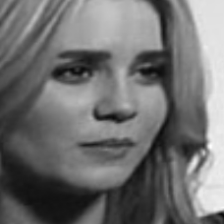

In [15]:
to_pil_transform(dataset[0][1])

In [16]:
dev_list()

[_CudaDeviceProperties(name='NVIDIA A100 80GB PCIe', major=8, minor=0, total_memory=81069MB, multi_processor_count=108),
 _CudaDeviceProperties(name='NVIDIA A100 80GB PCIe', major=8, minor=0, total_memory=81069MB, multi_processor_count=108),
 _CudaDeviceProperties(name='NVIDIA A100 80GB PCIe', major=8, minor=0, total_memory=81069MB, multi_processor_count=108),
 _CudaDeviceProperties(name='NVIDIA A100 80GB PCIe', major=8, minor=0, total_memory=81069MB, multi_processor_count=108)]

lr: 0.001


train 1/3: 100%|██████████| 203/203 [07:58<00:00,  2.36s/it]


loss: 0.524566392005958


train 2/3: 100%|██████████| 203/203 [07:29<00:00,  2.22s/it]


loss: 0.38138654901476327


train 3/3: 100%|██████████| 203/203 [07:20<00:00,  2.17s/it]

loss: 0.33234946345314015


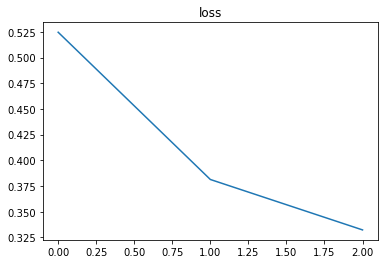

In [17]:
loss_history = train_triplet_multigpu(model, dataset, 3, batch_size=1024*len(dev_list()))
plt.plot(loss_history)
plt.title('loss');

```
ubuntu@a100x4:~$ nvidia-smi --query-gpu=memory.used,memory.free,utilization.gpu,utilization.memory,temperature.gpu,pstate --format=csv -l 1
memory.used [MiB], memory.free [MiB], utilization.gpu [%], utilization.memory [%], temperature.gpu, pstate
19611 MiB, 61458 MiB, 100 %, 82 %, 45, P0
19603 MiB, 61466 MiB, 100 %, 87 %, 46, P0
19407 MiB, 61662 MiB, 100 %, 80 %, 46, P0
19407 MiB, 61662 MiB, 100 %, 81 %, 45, P0
19611 MiB, 61458 MiB, 0 %, 0 %, 40, P0
19603 MiB, 61466 MiB, 0 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 41, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 41, P0
19611 MiB, 61458 MiB, 99 %, 69 %, 44, P0
19603 MiB, 61466 MiB, 100 %, 72 %, 46, P0
19407 MiB, 61662 MiB, 100 %, 70 %, 46, P0
19407 MiB, 61662 MiB, 100 %, 78 %, 45, P0
19611 MiB, 61458 MiB, 0 %, 0 %, 41, P0
19603 MiB, 61466 MiB, 0 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 41, P0
19611 MiB, 61458 MiB, 100 %, 89 %, 45, P0
19603 MiB, 61466 MiB, 70 %, 54 %, 47, P0
19407 MiB, 61662 MiB, 100 %, 88 %, 46, P0
19407 MiB, 61662 MiB, 74 %, 49 %, 46, P0
19611 MiB, 61458 MiB, 14 %, 0 %, 41, P0
19603 MiB, 61466 MiB, 65 %, 33 %, 43, P0
19407 MiB, 61662 MiB, 1 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 68 %, 35 %, 42, P0
19611 MiB, 61458 MiB, 62 %, 46 %, 44, P0
19603 MiB, 61466 MiB, 18 %, 2 %, 46, P0
19407 MiB, 61662 MiB, 75 %, 59 %, 45, P0
19407 MiB, 61662 MiB, 16 %, 1 %, 44, P0
19611 MiB, 61458 MiB, 73 %, 39 %, 42, P0
19603 MiB, 61466 MiB, 100 %, 82 %, 44, P0
19407 MiB, 61662 MiB, 60 %, 29 %, 43, P0
19407 MiB, 61662 MiB, 100 %, 82 %, 42, P0
19611 MiB, 61458 MiB, 0 %, 0 %, 40, P0
19603 MiB, 61466 MiB, 0 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 41, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 40, P0
19611 MiB, 61458 MiB, 0 %, 0 %, 40, P0
19603 MiB, 61466 MiB, 0 %, 0 %, 41, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 41, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 40, P0
19611 MiB, 61458 MiB, 0 %, 0 %, 39, P0
19603 MiB, 61466 MiB, 0 %, 0 %, 41, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 41, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 40, P0
19611 MiB, 61458 MiB, 100 %, 83 %, 46, P0
19603 MiB, 61466 MiB, 100 %, 78 %, 47, P0
19407 MiB, 61662 MiB, 100 %, 83 %, 46, P0
19407 MiB, 61662 MiB, 100 %, 76 %, 47, P0
19611 MiB, 61458 MiB, 0 %, 0 %, 40, P0
19603 MiB, 61466 MiB, 9 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 41, P0
19611 MiB, 61458 MiB, 99 %, 68 %, 45, P0
19603 MiB, 61466 MiB, 100 %, 88 %, 47, P0
19407 MiB, 61662 MiB, 100 %, 81 %, 47, P0
19407 MiB, 61662 MiB, 100 %, 69 %, 47, P0
19611 MiB, 61458 MiB, 0 %, 0 %, 41, P0
19603 MiB, 61466 MiB, 0 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 41, P0
19611 MiB, 61458 MiB, 99 %, 74 %, 45, P0
19603 MiB, 61466 MiB, 100 %, 74 %, 47, P0
19407 MiB, 61662 MiB, 100 %, 71 %, 46, P0
19407 MiB, 61662 MiB, 100 %, 82 %, 46, P0
19611 MiB, 61458 MiB, 0 %, 0 %, 41, P0
19603 MiB, 61466 MiB, 0 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 41, P0
19611 MiB, 61458 MiB, 99 %, 73 %, 46, P0
19603 MiB, 61466 MiB, 100 %, 85 %, 48, P0
19407 MiB, 61662 MiB, 100 %, 88 %, 47, P0
19407 MiB, 61662 MiB, 100 %, 70 %, 47, P0
19611 MiB, 61458 MiB, 0 %, 0 %, 41, P0
19603 MiB, 61466 MiB, 0 %, 0 %, 43, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 41, P0
19611 MiB, 61458 MiB, 99 %, 77 %, 45, P0
19603 MiB, 61466 MiB, 100 %, 72 %, 47, P0
19407 MiB, 61662 MiB, 100 %, 70 %, 46, P0
19407 MiB, 61662 MiB, 100 %, 82 %, 45, P0
19611 MiB, 61458 MiB, 0 %, 0 %, 41, P0
19603 MiB, 61466 MiB, 0 %, 0 %, 43, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 42, P0
19407 MiB, 61662 MiB, 0 %, 0 %, 41, P0
19611 MiB, 61458 MiB, 71 %, 55 %, 45, P0
19603 MiB, 61466 MiB, 100 %, 86 %, 47, P0
19407 MiB, 61662 MiB, 100 %, 88 %, 46, P0
19407 MiB, 61662 MiB, 69 %, 45 %, 46, P0
```

In [18]:
model.to(torch.device('cpu'));

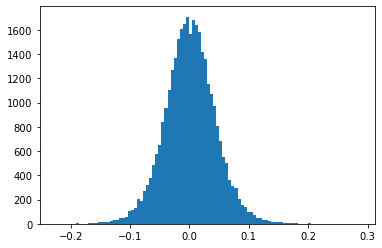

In [19]:
plt.hist(model.fc.weight.detach().reshape(-1).numpy(), bins=100);

In [20]:
def cos_similarity(v1, v2):
    val = np.inner(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return val.reshape(-1)[0]

def euc_similarity(v1, v2):
    return np.linalg.norm(v1-v2)

In [21]:
for i in range(10):
    v1 = model(dataset[42][0].reshape(1, 1, 224, 224)).detach().numpy()
    v2 = model(dataset[42][1].reshape(1, 1, 224, 224)).detach().numpy()
    v3 = model(dataset[42][2].reshape(1, 1, 224, 224)).detach().numpy()
    print(euc_similarity(v1, v2), euc_similarity(v1, v3),
          cos_similarity(v1, v2), cos_similarity(v1, v3),
          np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())

0.8879008 2.0288703 0.9794084 0.9756244 -0.73173624 2.9556692
1.4792317 1.1072022 0.91937876 0.97469664 -0.715692 2.702318
1.5092613 1.1398923 0.9421711 0.95325774 -0.8901722 2.6254876
0.933165 1.7875792 0.97939414 0.9131056 -0.5339811 2.6297295
1.2873085 1.1076018 0.9501939 0.89598376 -0.5044325 2.1880877
0.94873434 0.87790304 0.93973714 0.9546939 -0.51404744 1.9086801
2.0018878 1.441686 0.95492494 0.9515905 -0.8521149 2.7731168
0.89473295 1.1153042 0.98788655 0.9423528 -0.48160923 2.2468483
1.4658844 1.0661907 0.93257236 0.9263525 -0.82708085 2.4495714
1.2203046 1.2086713 0.949252 0.927569 -0.6437616 2.429184


In [22]:
torch.save(model, f'faceid-model-{loss_history[-1]}.pt')

In [23]:
dataset.resize(anchor_set_len=5, positive_set_len=5, negative_set_len=5)
len(dataset)

103500

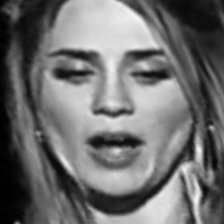

In [24]:
to_pil_transform(dataset[0][1])

lr: 1e-06


train 1/3: 100%|██████████| 102/102 [02:01<00:00,  1.19s/it]


loss: 0.2999158270803152


train 2/3: 100%|██████████| 102/102 [01:58<00:00,  1.16s/it]


loss: 0.2831086964876044


train 3/3: 100%|██████████| 102/102 [02:01<00:00,  1.19s/it]

loss: 0.2709958381658676


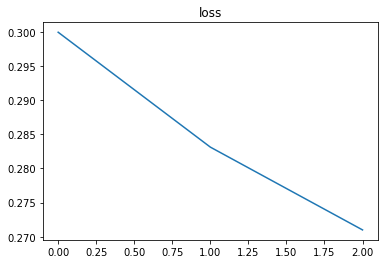

In [25]:
model.requires_grad_(True)
loss_history = train_triplet_multigpu(model, dataset, 3, target_loss=0.01, lr=0.000001, batch_size=256*len(dev_list()))
plt.plot(loss_history)
plt.title('loss');

```
ubuntu@a100x4:~$ nvidia-smi --query-gpu=memory.used,memory.free,utilization.gpu,utilization.memory,temperature.gpu,pstate --format=csv -l 1
memory.used [MiB], memory.free [MiB], utilization.gpu [%], utilization.memory [%], temperature.gpu, pstate
67401 MiB, 13668 MiB, 49 %, 33 %, 45, P0
67549 MiB, 13520 MiB, 46 %, 32 %, 47, P0
67549 MiB, 13520 MiB, 86 %, 61 %, 46, P0
67451 MiB, 13618 MiB, 56 %, 34 %, 46, P0
67401 MiB, 13668 MiB, 12 %, 3 %, 44, P0
67549 MiB, 13520 MiB, 7 %, 0 %, 46, P0
67549 MiB, 13520 MiB, 47 %, 32 %, 45, P0
67451 MiB, 13618 MiB, 11 %, 2 %, 45, P0
67401 MiB, 13668 MiB, 4 %, 1 %, 44, P0
67549 MiB, 13520 MiB, 10 %, 0 %, 45, P0
67549 MiB, 13520 MiB, 7 %, 0 %, 45, P0
67451 MiB, 13618 MiB, 0 %, 0 %, 44, P0
67401 MiB, 13668 MiB, 51 %, 18 %, 43, P0
67549 MiB, 13520 MiB, 58 %, 25 %, 44, P0
67549 MiB, 13520 MiB, 5 %, 0 %, 44, P0
67451 MiB, 13618 MiB, 37 %, 12 %, 43, P0
67401 MiB, 13668 MiB, 96 %, 57 %, 43, P0
67549 MiB, 13520 MiB, 100 %, 63 %, 45, P0
67549 MiB, 13520 MiB, 50 %, 19 %, 44, P0
67451 MiB, 13618 MiB, 81 %, 44 %, 43, P0
67401 MiB, 13668 MiB, 100 %, 85 %, 45, P0
67549 MiB, 13520 MiB, 100 %, 86 %, 47, P0
67549 MiB, 13520 MiB, 100 %, 61 %, 46, P0
67451 MiB, 13618 MiB, 100 %, 80 %, 46, P0
67401 MiB, 13668 MiB, 100 %, 85 %, 46, P0
67549 MiB, 13520 MiB, 100 %, 85 %, 48, P0
67549 MiB, 13520 MiB, 100 %, 85 %, 48, P0
67451 MiB, 13618 MiB, 100 %, 85 %, 47, P0
67401 MiB, 13668 MiB, 100 %, 78 %, 46, P0
67549 MiB, 13520 MiB, 100 %, 75 %, 48, P0
67549 MiB, 13520 MiB, 100 %, 85 %, 47, P0
67451 MiB, 13618 MiB, 100 %, 81 %, 47, P0
67401 MiB, 13668 MiB, 0 %, 0 %, 42, P0
67549 MiB, 13520 MiB, 0 %, 0 %, 44, P0
67549 MiB, 13520 MiB, 0 %, 0 %, 43, P0
67451 MiB, 13618 MiB, 0 %, 0 %, 42, P0
67401 MiB, 13668 MiB, 0 %, 0 %, 41, P0
67549 MiB, 13520 MiB, 0 %, 0 %, 43, P0
67549 MiB, 13520 MiB, 0 %, 0 %, 42, P0
67451 MiB, 13618 MiB, 0 %, 0 %, 41, P0
67401 MiB, 13668 MiB, 51 %, 36 %, 45, P0
67549 MiB, 13520 MiB, 39 %, 31 %, 46, P0
67549 MiB, 13520 MiB, 100 %, 70 %, 45, P0
67451 MiB, 13618 MiB, 69 %, 51 %, 45, P0
67401 MiB, 13668 MiB, 25 %, 16 %, 44, P0
67549 MiB, 13520 MiB, 10 %, 2 %, 46, P0
67549 MiB, 13520 MiB, 0 %, 0 %, 45, P0
67451 MiB, 13618 MiB, 34 %, 23 %, 45, P0
```

In [26]:
model.to(torch.device('cpu'));

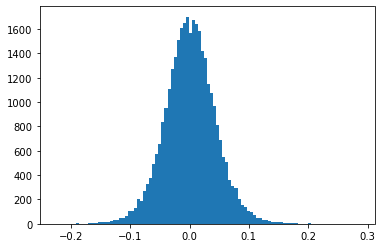

In [27]:
plt.hist(model.fc.weight.detach().reshape(-1).numpy(), bins=100);

In [28]:
for i in range(10):
    v1 = model(dataset[42][0].reshape(1, 1, 224, 224)).detach().numpy()
    v2 = model(dataset[42][1].reshape(1, 1, 224, 224)).detach().numpy()
    v3 = model(dataset[42][2].reshape(1, 1, 224, 224)).detach().numpy()
    print(euc_similarity(v1, v2), euc_similarity(v1, v3),
          cos_similarity(v1, v2), cos_similarity(v1, v3),
          np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())

1.5913832 1.3940783 0.95483774 0.860075 -0.67000544 2.3528988
1.0291426 2.132972 0.94984597 0.90834767 -0.70332235 2.577653
1.325088 1.6475036 0.9497791 0.9507931 -1.0570644 2.90987
1.1820004 0.9047441 0.96103776 0.92304844 -0.50572795 2.0245397
1.2343583 0.94251716 0.97708714 0.98023283 -0.7172505 2.6193829
1.626974 1.0575576 0.90308124 0.95954996 -0.80430925 2.2554433
1.1682502 0.6851614 0.9780239 0.98059285 -0.8626897 2.6029706
0.9878555 1.1197045 0.97437114 0.9552841 -0.7947447 2.5557837
0.93402195 1.5320942 0.9596778 0.9187997 -0.7012531 2.4177608
0.9345146 1.3270934 0.9703943 0.9203027 -0.73083925 2.3217807


In [29]:
torch.save(model, f'faceid-model-{loss_history[-1]}.pt')
!ls -l faceid-model-*.pt

-rw-rw-r-- 1 ubuntu ubuntu 94480369 Oct 18 11:55 faceid-model-0.2709958381658676.pt
-rw-rw-r-- 1 ubuntu ubuntu 94480691 Oct 18 11:49 faceid-model-0.33234946345314015.pt
